In [1]:
from matplotlib import pyplot as plt
import numpy as np
import PyPore
from PyPore.DataTypes import *
import seaborn as sns
import sys
import os
import random
from Analysis_helpers import TraceFile, FilterDerivativeParser


def prepareFiles(directory,inputDict,included_terms=["175"], excluded_terms=[],verbose=False ,acceptedExts={".bin",".opt",".abf"},meta_format="json"):
    for root,dirs,files in os.walk(directory,topdown=True):
        for name in files:
            for key,value in inputDict.items():
                if (root.find(key) != -1 and 
                       all(root.find(in_term) != -1 for in_term in included_terms) and
                       not any(name.find(ex_term) != -1 for ex_term in excluded_terms)): 
                    if os.path.splitext(name)[1]==".bin":
                        value.append(os.path.join(root,name))

# Data Preparation
### load data files, organize them, and parse into events using FilterDerivativeParser

In [2]:
#define keywords in file directory that separate datafiles
experimentfiles={"_ MBP10D":[],"_ MBPMBP10D":[],"_ MBP Nterm":[]}

##data_directory="D:\\ProteinData\\Meni" #Example of our directory where the experimental files were located
data_directory="<put_your_directory_to_experiment_files_here>"
prepareFiles(data_directory,experimentfiles,excluded_terms=["22_"]) #exclude recent MBP-D10 data collected in 2022 
experimentfilesmod={}
experiments={}

for key,value in experimentfiles.items():
    print(key[2:]," ")
    experimentfilesmod[key[2:]] = value #Redefine keys to eliminate "_ " in the beginning
    experiments[key[2:]]=[]
    for filename in value:
        print(" ",filename)
    print(" ")

print (experiments)

import time
t=time.time()
# now read and parse each datafile into events. 
for key,filenames in experimentfilesmod.items():
    for filename in filenames:
        experiments[key].append(TraceFile(filename))
        #threads.append(threading.Thread(name="thread:"+filename, target=experiments[key][-1].parse, 
        #                   kwargs=dict(parser=MyFilterDerivativeSegmenter(sampling_freq=experiments[key][-1].second,cutoff_freq=5000,low_threshold=0.01,high_threshold=0.015))))
        experiments[key][-1].parse(parser=FilterDerivativeParser(sampling_freq=experiments[key][-1].second,cutoff_freq=5000,low_threshold=0.01,high_threshold=0.015))
print (f"elapsed time:{time.time()-t:.3f}s")

MBP10D  
  D:\ProteinData\Meni\alphaHL_ MBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B081920_006_trace_10kHz.bin
  D:\ProteinData\Meni\alphaHL_ MBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B081920_007_trace_10kHz.bin
  D:\ProteinData\Meni\alphaHL_ MBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B081920_008_trace_10kHz.bin
  D:\ProteinData\Meni\alphaHL_ MBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B081920_009_trace_10kHz.bin
 
MBPMBP10D  
  D:\ProteinData\Meni\alphaHL_ MBPMBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B090120_004_trace_10kHz.bin
  D:\ProteinData\Meni\alphaHL_ MBPMBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B090220_004_trace_10kHz.bin
 
MBP Nterm  
  D:\ProteinData\Meni\alphaHL_ MBP Nterm 10D_1M KCl_2M GdnHCl_PH7.5 traces 10kHz filter\175mV\B090320_000_trace_10kHz.bin
  D:\ProteinData\Meni\alphaHL_ MBP Nterm 10D_1M KCl_2M GdnHCl_PH7.5 traces 10kHz filter\175mV\B090320_001_trace_10kHz.bin
  D:\ProteinData\

Text(0.5, 1.0, '')

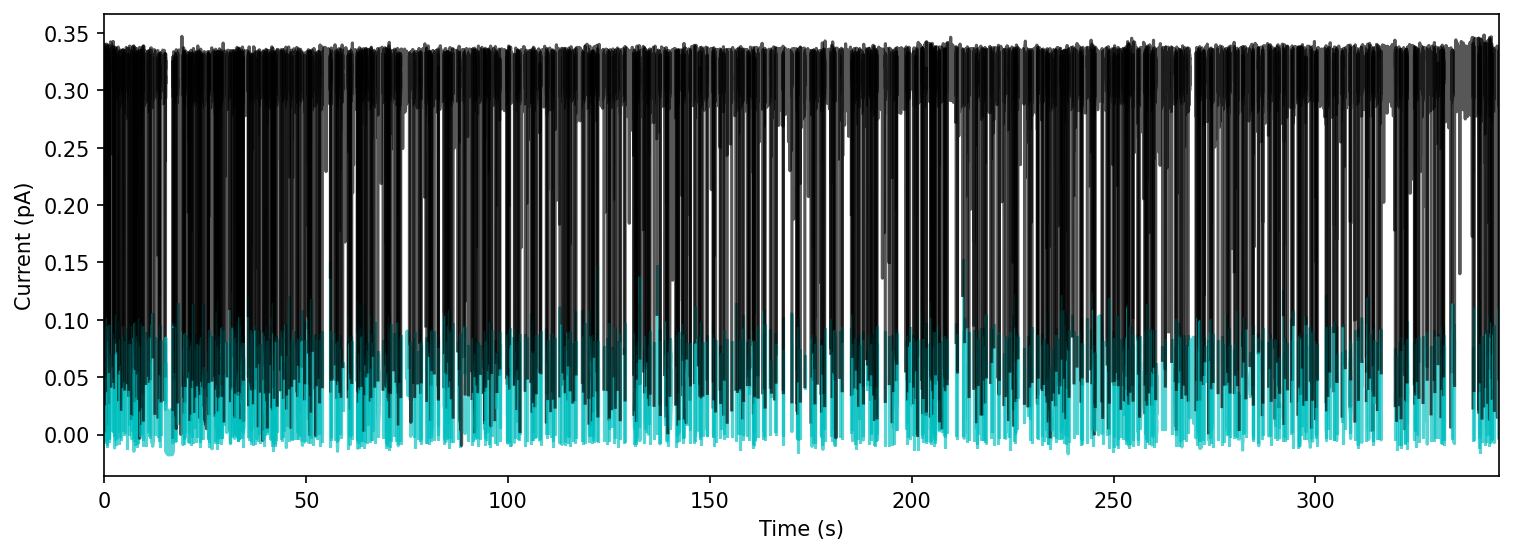

In [4]:
# plot example parsed trace
plt.figure(figsize=(12,4),dpi=150)
experiments['MBPMBP10D'][0].plot()
plt.title("")


In [5]:
#There's a rare artifact from the DAQ card where some portions of data get repeated. 
#This code cleans that up and removes copied events

for key, experiment in experiments.items():
    
    # first select a wide range of events to be used later
    events=[event for file in experiment for event in file.events if event.duration>0.3e-3 and event.duration<20e-3]
    
    #identify duplicates by first comparing exact dwell times and then minima (1 vs all)
    duplicates = [event for event in events if [eventx.duration for eventx in events].count(event.duration) > 1] 
    duplicates= [event for event in duplicates if [eventx.min for eventx in duplicates].count(event.min) > 1]

    #select events that did not show up as duplicates
    select_events=[event for event in events if event not in duplicates]
    
    print(key)
    print("  total:",len(events))
    print("  duplicate free:",len(select_events))
    
    experiments[key]=select_events


MBP10D
  total: 866
  duplicate free: 854
MBPMBP10D
  total: 717
  duplicate free: 713
MBP Nterm
  total: 504
  duplicate free: 488


# Dynamic Time Warping
## Soft-DTW barycenter computation

In [16]:
#import all DTW functionality 
import tslearn
from tslearn.metrics import soft_dtw,gamma_soft_dtw
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.barycenters import softdtw_barycenter,euclidean_barycenter

print (tslearn.__version__)

0.6.3


In [7]:
#calculate Barycenter for a given set and plot the curve with the event current backdrops
def barycenter_plot(events,resample_to=400, gamma=None, label="",tol=0.001,c='g',alphahaze=0.2):
    
    #resample all events in the set to a fixed size
    resampler_long=TimeSeriesResampler(sz=resample_to)
    currents_resampled=[resampler_long.fit_transform(event.current/event.I_0).ravel() for event in events]
    print("resampling size: ", resample_to)
    
    if gamma is None: # if gamma is not provided..
        gammas=[]
        for i in range (30):
            gammas.append(gamma_soft_dtw(currents_resampled[:],len(currents_resampled),i)) 
        gamma=np.mean(gammas) #estimate an optimal gamma by averaging many guesses
        print("auto gamma: ",gamma)
    else: # otherwise use the provided gamma
        print("gamma: ",gamma)
        
    # Now calculate the barycenter curve (b) for all events in the set using gamma    
    b=softdtw_barycenter(currents_resampled[:],max_iter=800,gamma=gamma,tol=1e-7) 
      
    # first plot the backdrops
    plt.plot (currents_resampled[0].ravel(), c='k',alpha=alphahaze,linewidth=0.2, label="50 resampled events")
    for i in range (1,len(events)):
        plt.plot (currents_resampled[i*1].ravel(), c='k',alpha=alphahaze,linewidth=0.2)
        
    # Then plot the barycenter curve   
    plt.plot (b,c=c,alpha=0.9, label= f'{label} soft DTW barycenter',linewidth=3)
    return(gamma)

In [8]:
# take dwell time ranges to include for monomer and dimer events
# make a 3 panel figure, each panel showing soft-DTW barycenter of one of the variants. 
# call barycenter_plot on each variant to compute and plot resampled events in the background 
# and SoftDTW barycenter in the foreground
# if limit is set to True, find the variant with the smallest number of events and randomly sample the other two variants to obtain the same number of events
# if limit is set to False, use all events in each variant's set for the DTW computation


def select_and_plot(dwell_monomer=[3e-3,5e-3], dwell_dimer=[6e-3,9e-3], limit=True,alphahaze=0.2):
    #filter and select a range of events from each variant
    events_D10MBP=[event for event in experiments["MBP Nterm"] if event.duration>dwell_monomer[0] and event.duration<dwell_monomer[1] and event.max<0.13]
    events_MBPD10=[event for event in experiments["MBP10D"] if event.duration>dwell_monomer[0] and event.duration<dwell_monomer[1] and event.max<0.13]
    events_diMBPD10=[event for event in experiments["MBPMBP10D"] if event.duration>dwell_dimer[0] and event.duration<dwell_dimer[1] and event.max<0.13]
    print("# events in filtered selection:")
    print("MBP-D10:\t",len(events_MBPD10))
    print("D10-MBP:\t",len(events_D10MBP))
    print("diMBP-D10:\t",len(events_diMBPD10))

    n=min(len(events_D10MBP),len(events_MBPD10),len(events))
    random.seed(20) #arbitrary seed to initialize the random generator, for reproducibility in the future

    if limit:
        events_MBPD10=random.sample(events_MBPD10,n)
        events_D10MBP=random.sample(events_D10MBP,n)
        events_diMBPD10=random.sample(events_diMBPD10,n)


    from matplotlib import gridspec
    print("# sampled events:")
    print("MBP-D10:\t",len(events_MBPD10))
    print("D10-MBP:\t",len(events_D10MBP))
    print("diMBP-D10:\t",len(events_diMBPD10))

    # create 3-panel figure and plot each variant
    fig=plt.figure(figsize=(11,3),dpi=300)
    gs = gridspec.GridSpec(1, 3, width_ratios=[3,3,5]) 


    ax=plt.subplot(gs[0])
    gamma=barycenter_plot(events_MBPD10,resample_to=300,label='MBP-D10',c='orange',alphahaze=alphahaze)


    ax.set_title(f"MBP-D10, n={len(events_MBPD10)}")
    plt.xlim(-30,330)
    ax.tick_params('y',direction='in')


    ax=plt.subplot(gs[1],sharey=ax)
    ax.tick_params('y',direction='in')

    gamma=barycenter_plot(events_D10MBP,resample_to=300,label='D10-MBP',c='r',alphahaze=alphahaze)
    plt.xlim(-30,330)
    ax.set_title(f"D10-MBP, n={len(events_D10MBP)}")
    plt.setp(ax.get_yticklabels(), visible=False)


    ax=plt.subplot(gs[2],sharey=ax)
    ax.tick_params('y',direction='in')
    gamma=barycenter_plot(events_diMBPD10,resample_to=500,label='diMBP-D10',c='mediumseagreen',alphahaze=alphahaze)

    plt.ylim(-0.04,0.39)
    plt.xlim(-30,530)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_title(f"diMBP-D10, n={len(events_diMBPD10)}")

    plt.subplots_adjust(wspace=.0)


    fig.supylabel(r"$I\,/\,I_0$",x=0.07)
    fig.supxlabel('Segment index',y=-0.01)
    return fig

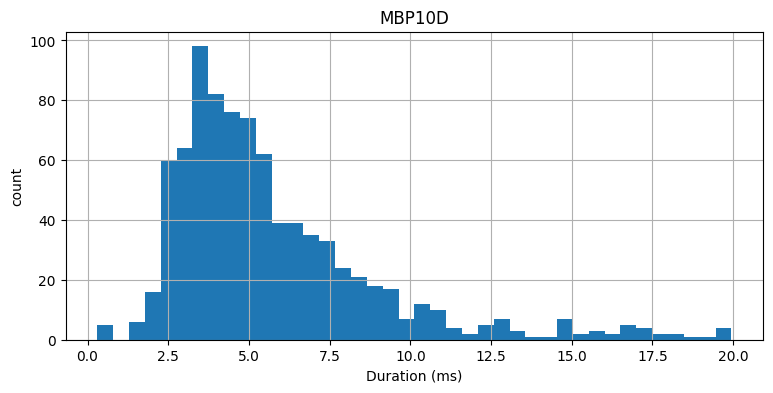

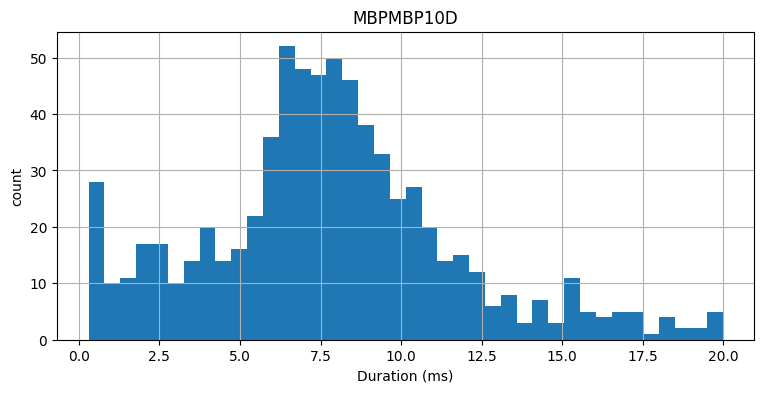

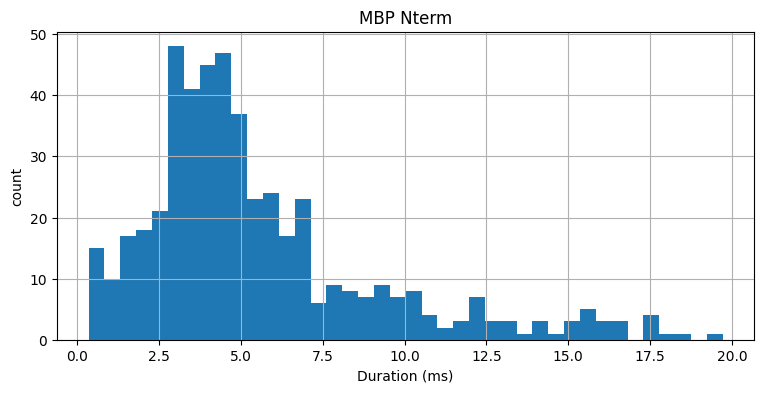

In [9]:
# plot histograms of duration to illustrate what the next filtering steps will select
for key,events in experiments.items():
    plt.figure(figsize=(9,4))
    plt.hist([(event.duration*1000) for event in events],bins=40)
    plt.title(key)
    plt.xlabel("Duration (ms)")
    plt.ylabel("count")
    plt.grid()
    

# events in filtered selection:
MBP-D10:	 331
D10-MBP:	 174
diMBP-D10:	 288
# sampled events:
MBP-D10:	 331
D10-MBP:	 174
diMBP-D10:	 288
resampling size:  300
auto gamma:  1.6419643792330065
resampling size:  300
auto gamma:  2.3512218666318128
resampling size:  500
auto gamma:  2.749384675890375


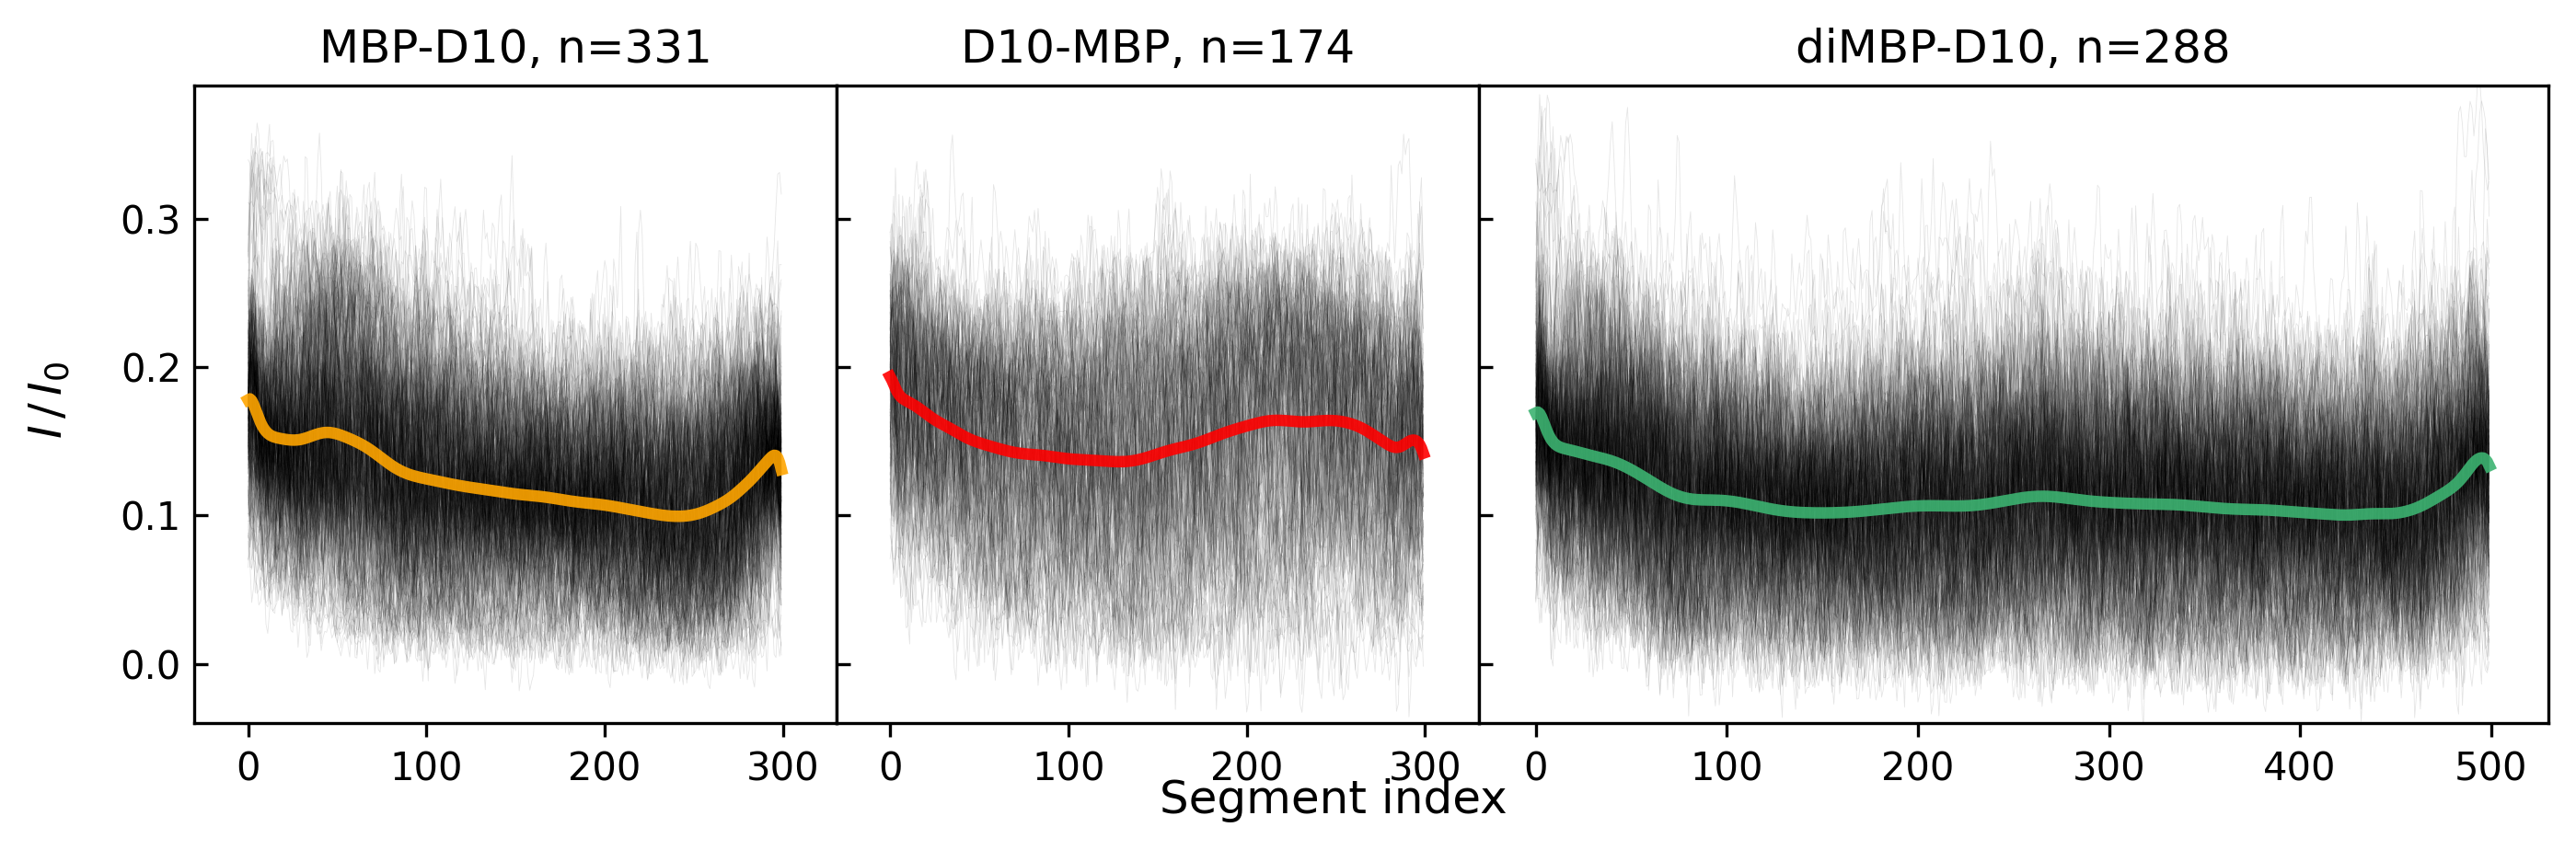

In [10]:
# Figure 4A - monomer events from 3 to 5 ms, dimer events from 6 to 9 ms.
fig=select_and_plot([3e-3, 5e-3 ],[6e-3,9e-3],False,alphahaze=0.1)

# events in filtered selection:
MBP-D10:	 760
D10-MBP:	 405
diMBP-D10:	 607
# sampled events:
MBP-D10:	 760
D10-MBP:	 405
diMBP-D10:	 607
resampling size:  300
auto gamma:  1.8178745479219125
resampling size:  300
auto gamma:  2.555959975575556
resampling size:  500
auto gamma:  3.085264573338845


Text(0.662, 0.98, '$3 $ms$ < t_{dwell} < 18 $ms')

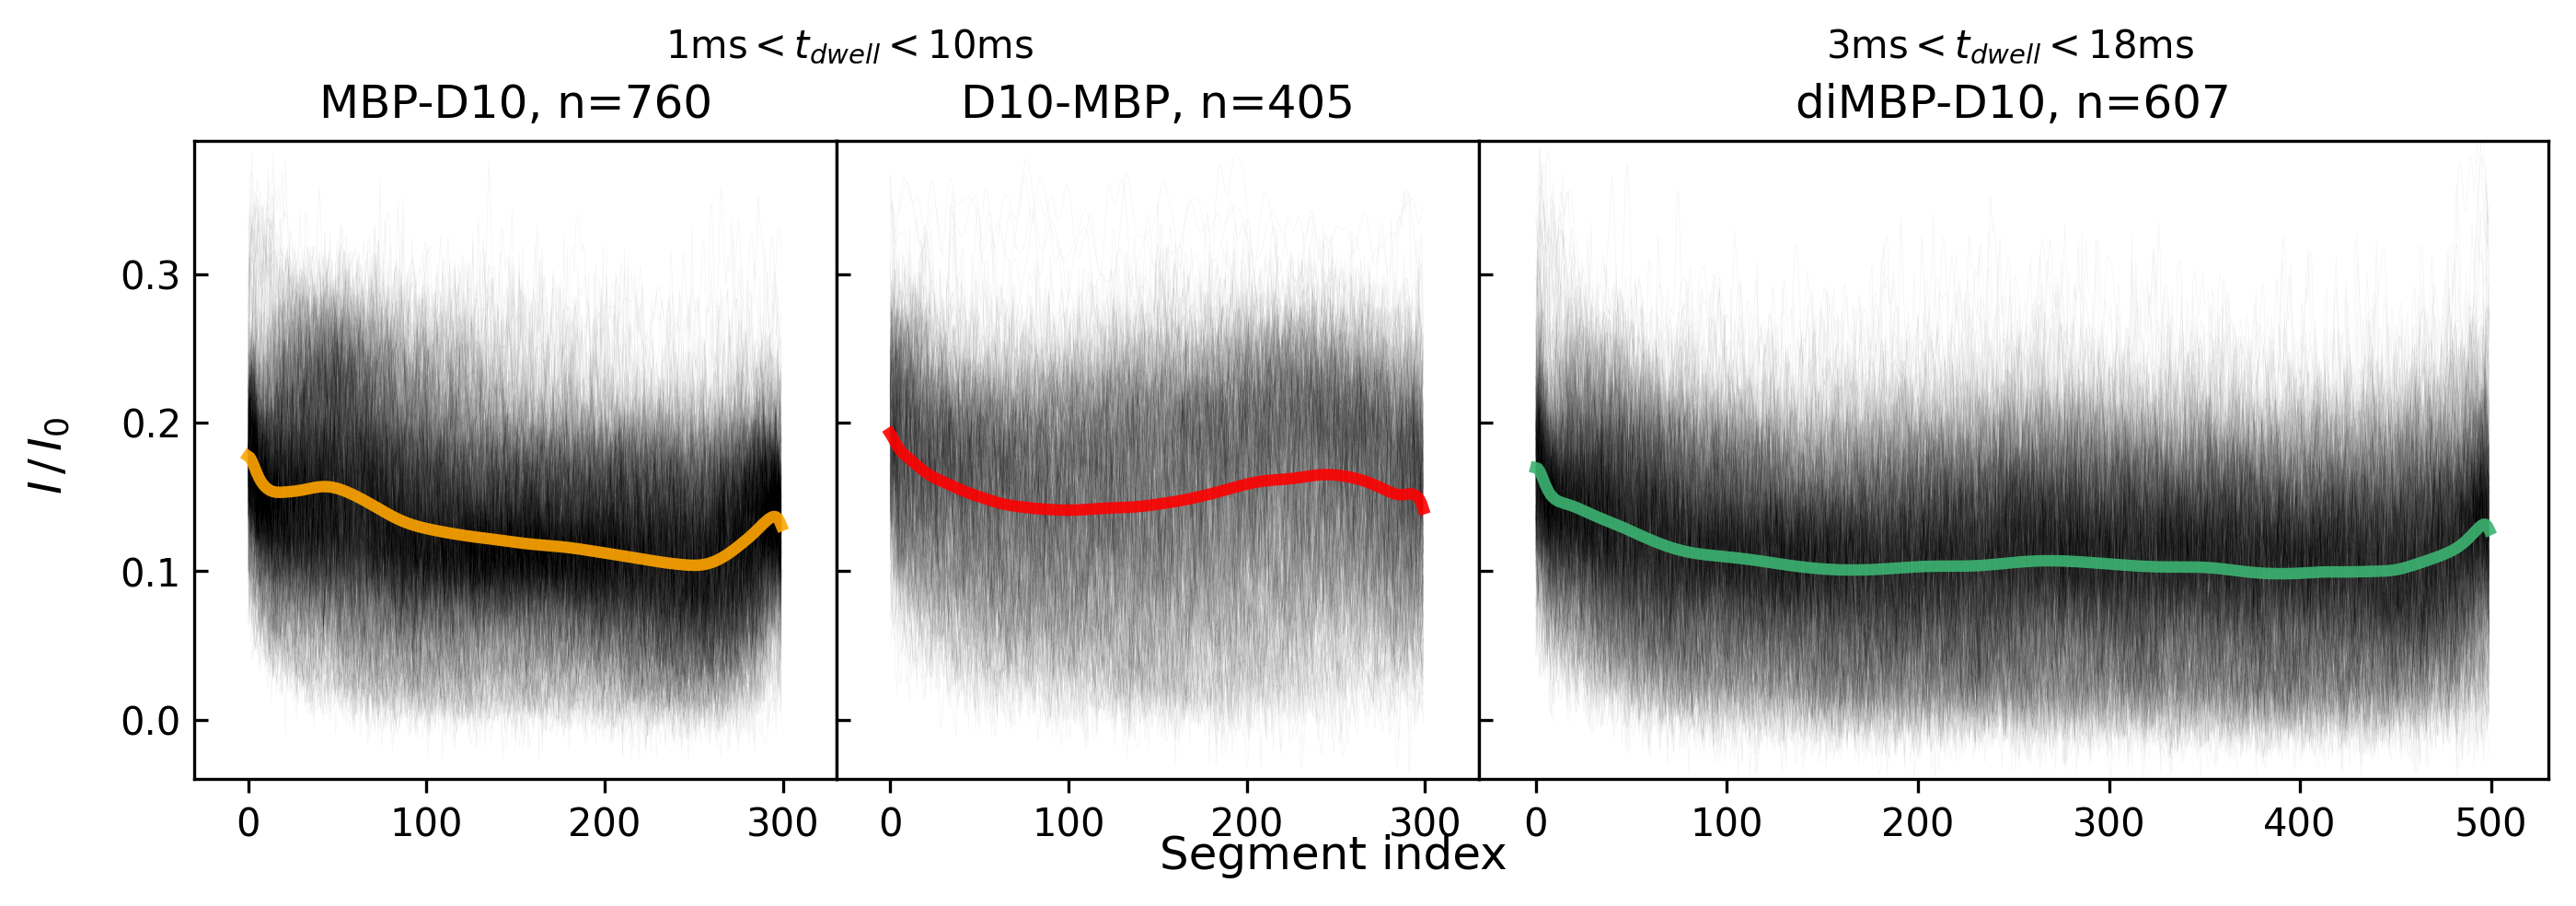

In [11]:
# Fig S33.A
fig=select_and_plot([1e-3, 10e-3 ],[3e-3,18e-3],False,alphahaze=0.04)
plt.figure(fig)
fig.text(0.28,0.98,r"$1 $ms$ < t_{dwell} < 10 $ms")
fig.text(0.662,0.98,r"$3 $ms$ < t_{dwell} < 18 $ms")

# events in filtered selection:
MBP-D10:	 540
D10-MBP:	 286
diMBP-D10:	 502
# sampled events:
MBP-D10:	 540
D10-MBP:	 286
diMBP-D10:	 502
resampling size:  300
auto gamma:  1.6945996746271648
resampling size:  300
auto gamma:  2.3577418569514985
resampling size:  500
auto gamma:  2.9707528414668953


Text(0.662, 0.98, '$4 $ms$ < t_{dwell} < 12 $ms')

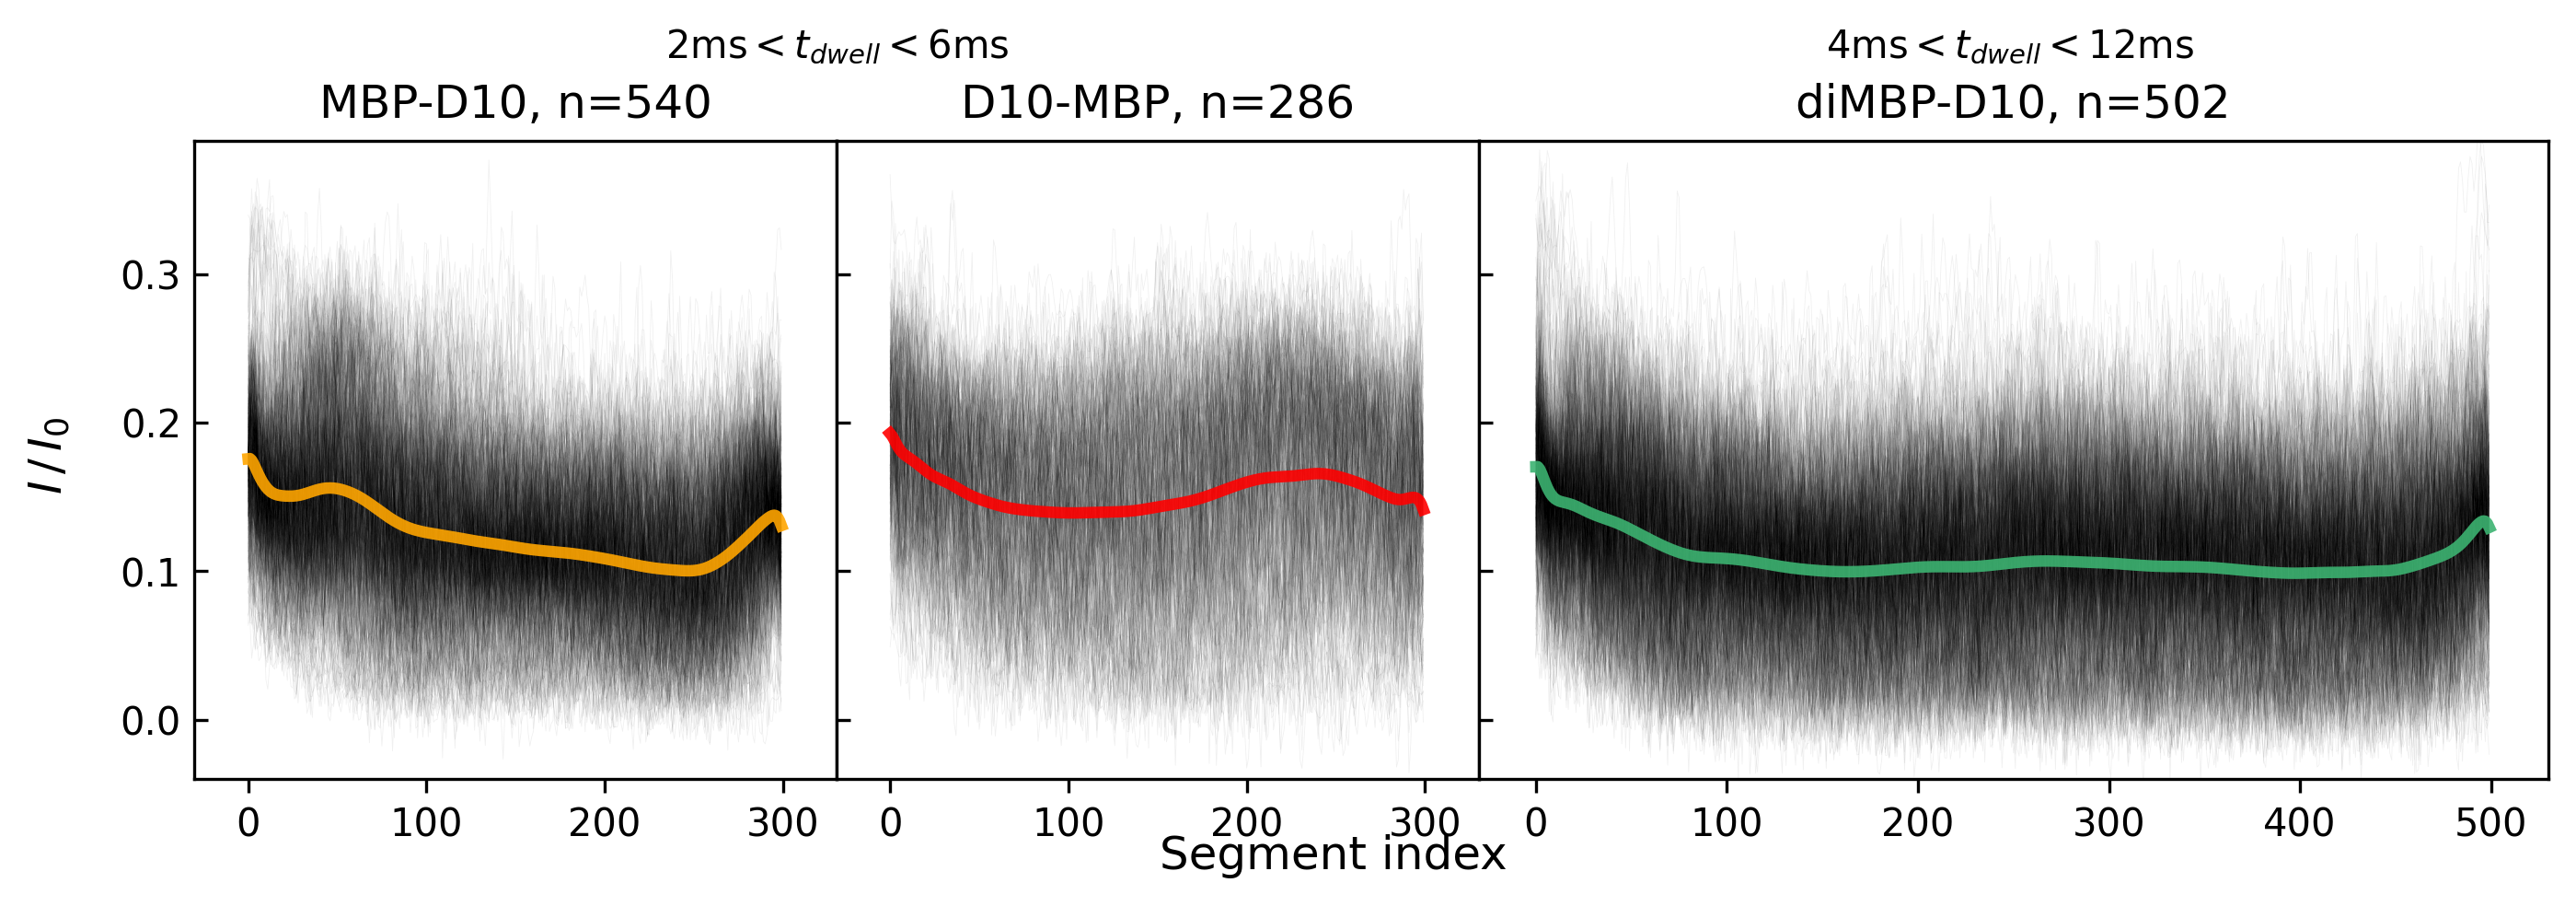

In [12]:
# Fig S33.B
fig=select_and_plot([2e-3, 6e-3 ],[4e-3,12e-3],False,alphahaze=0.06)
plt.figure(fig)
fig.text(0.28,0.98,r"$2 $ms$ < t_{dwell} < 6 $ms")
fig.text(0.662,0.98,r"$4 $ms$ < t_{dwell} < 12 $ms")

# events in filtered selection:
MBP-D10:	 331
D10-MBP:	 174
diMBP-D10:	 288
# sampled events:
MBP-D10:	 331
D10-MBP:	 174
diMBP-D10:	 288
resampling size:  300
auto gamma:  1.6419643792330065
resampling size:  300
auto gamma:  2.3512218666318128
resampling size:  500
auto gamma:  2.749384675890375


Text(0.662, 0.98, '$6 $ms$ < t_{dwell} < 9 $ms')

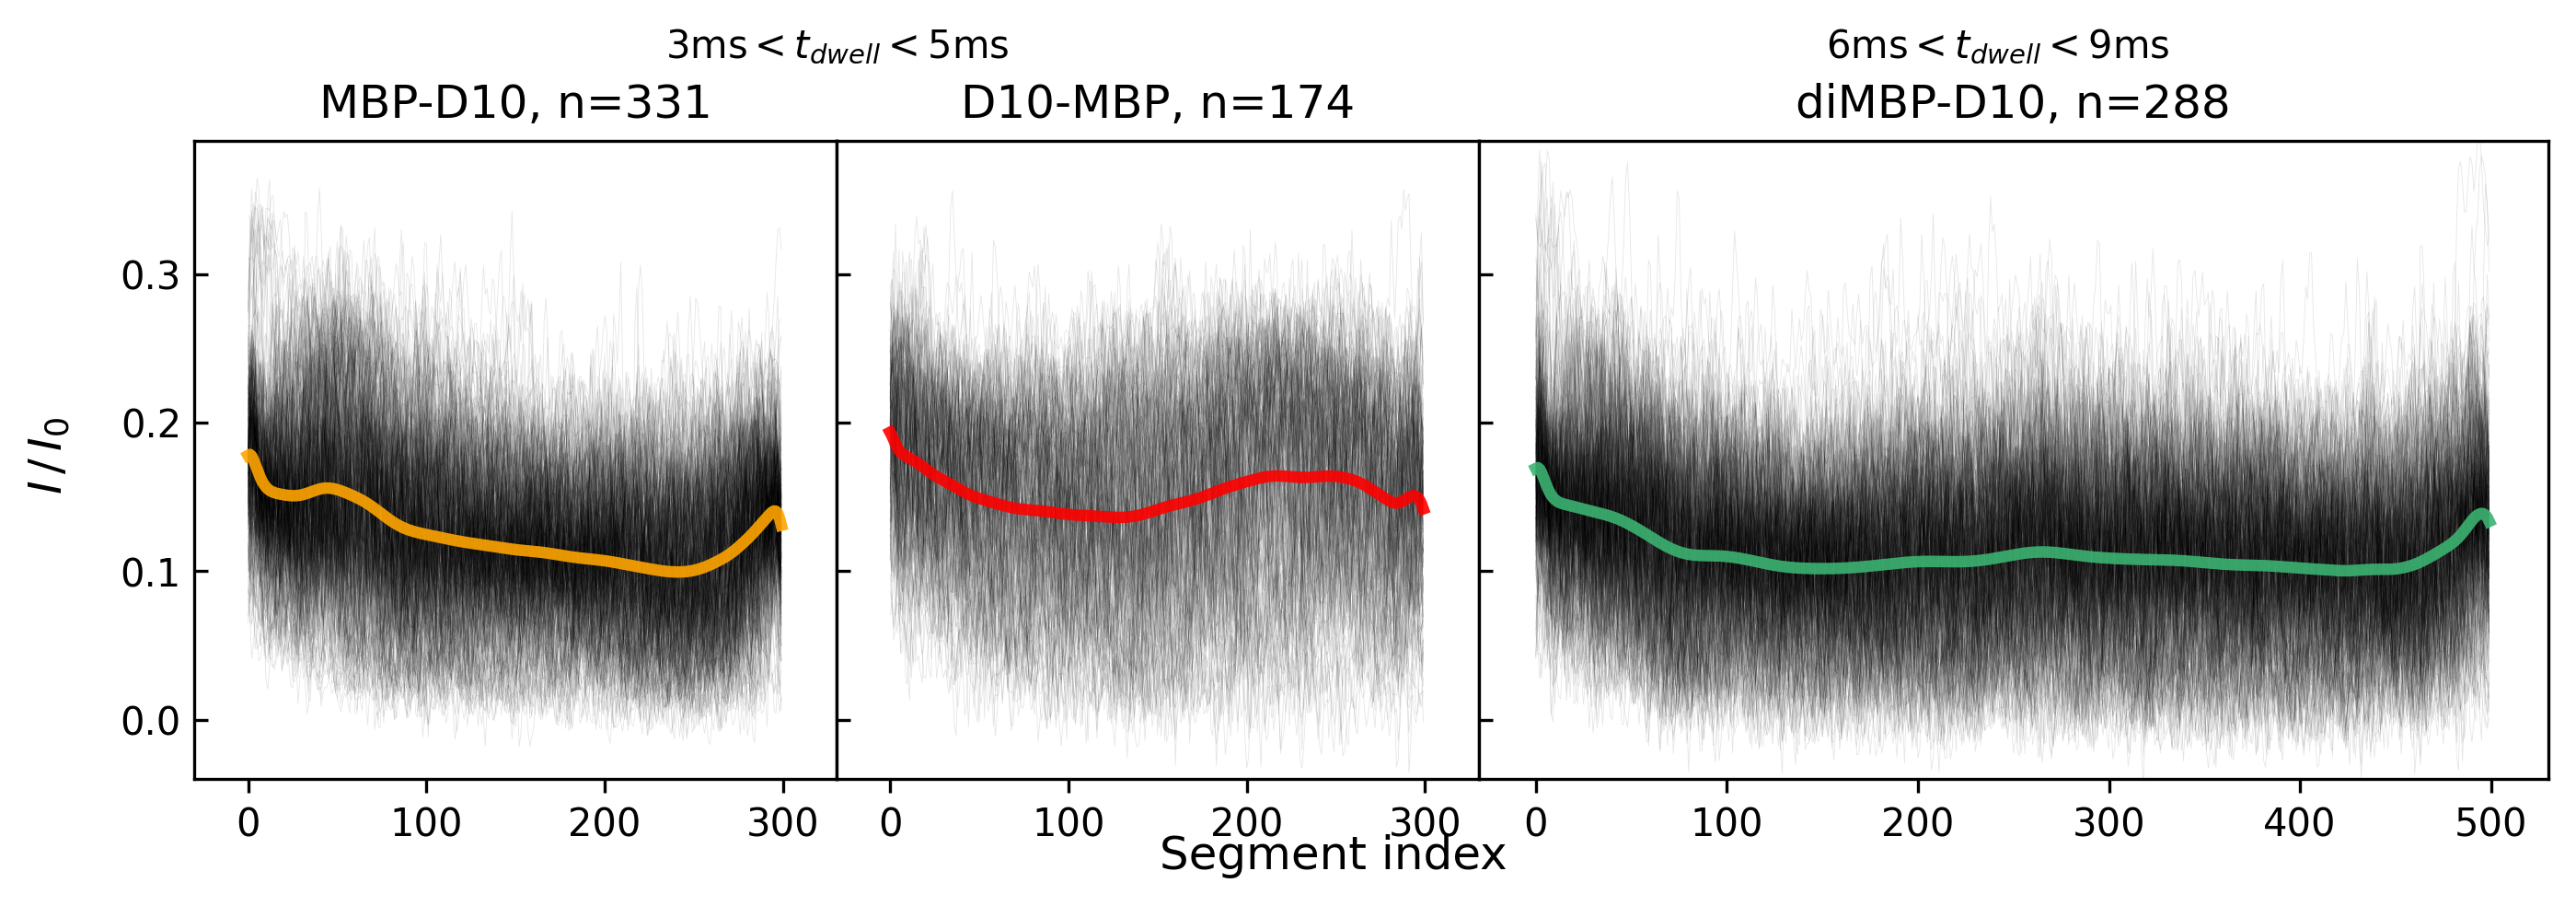

In [13]:
# Fig S33.C, same as Fig 4A
fig=select_and_plot([3e-3, 5e-3 ],[6e-3,9e-3],False,alphahaze=0.1)
plt.figure(fig)
fig.text(0.28,0.98,r"$3 $ms$ < t_{dwell} < 5 $ms")
fig.text(0.662,0.98,r"$6 $ms$ < t_{dwell} < 9 $ms")

# events in filtered selection:
MBP-D10:	 184
D10-MBP:	 91
diMBP-D10:	 146
# sampled events:
MBP-D10:	 184
D10-MBP:	 91
diMBP-D10:	 146
resampling size:  300
auto gamma:  1.6128097742651286
resampling size:  300
auto gamma:  2.3053178853646945
resampling size:  500
auto gamma:  2.818756178375658


Text(0.662, 0.98, '$6.5 $ms$ < t_{dwell} < 8 $ms')

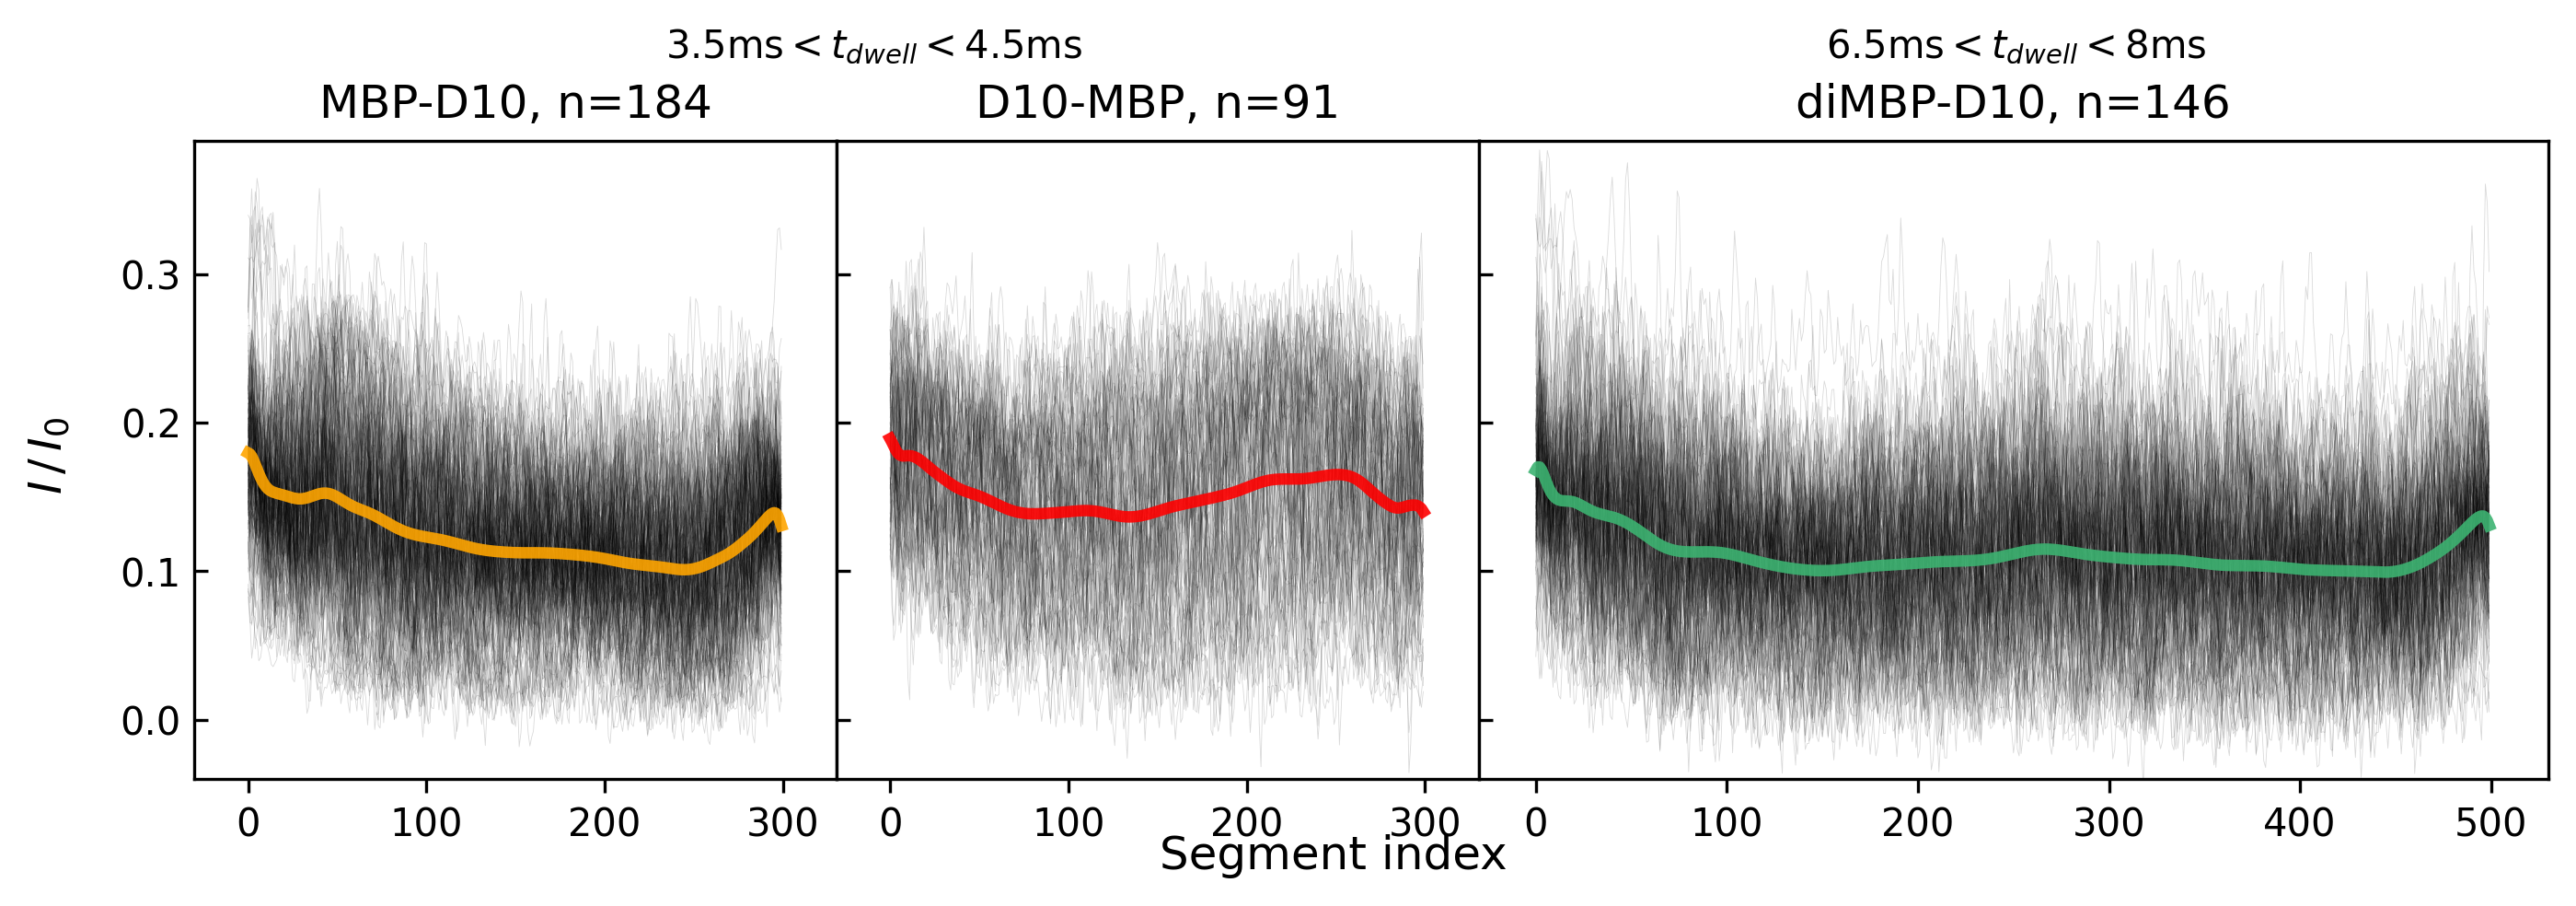

In [14]:
# Fig S33D
fig=select_and_plot([3.5e-3, 4.5e-3 ],[6.5e-3,8e-3],False,alphahaze=0.15)
plt.figure(fig)
fig.text(0.28,0.98,r"$3.5 $ms$ < t_{dwell} < 4.5 $ms")
fig.text(0.662,0.98,r"$6.5 $ms$ < t_{dwell} < 8 $ms")

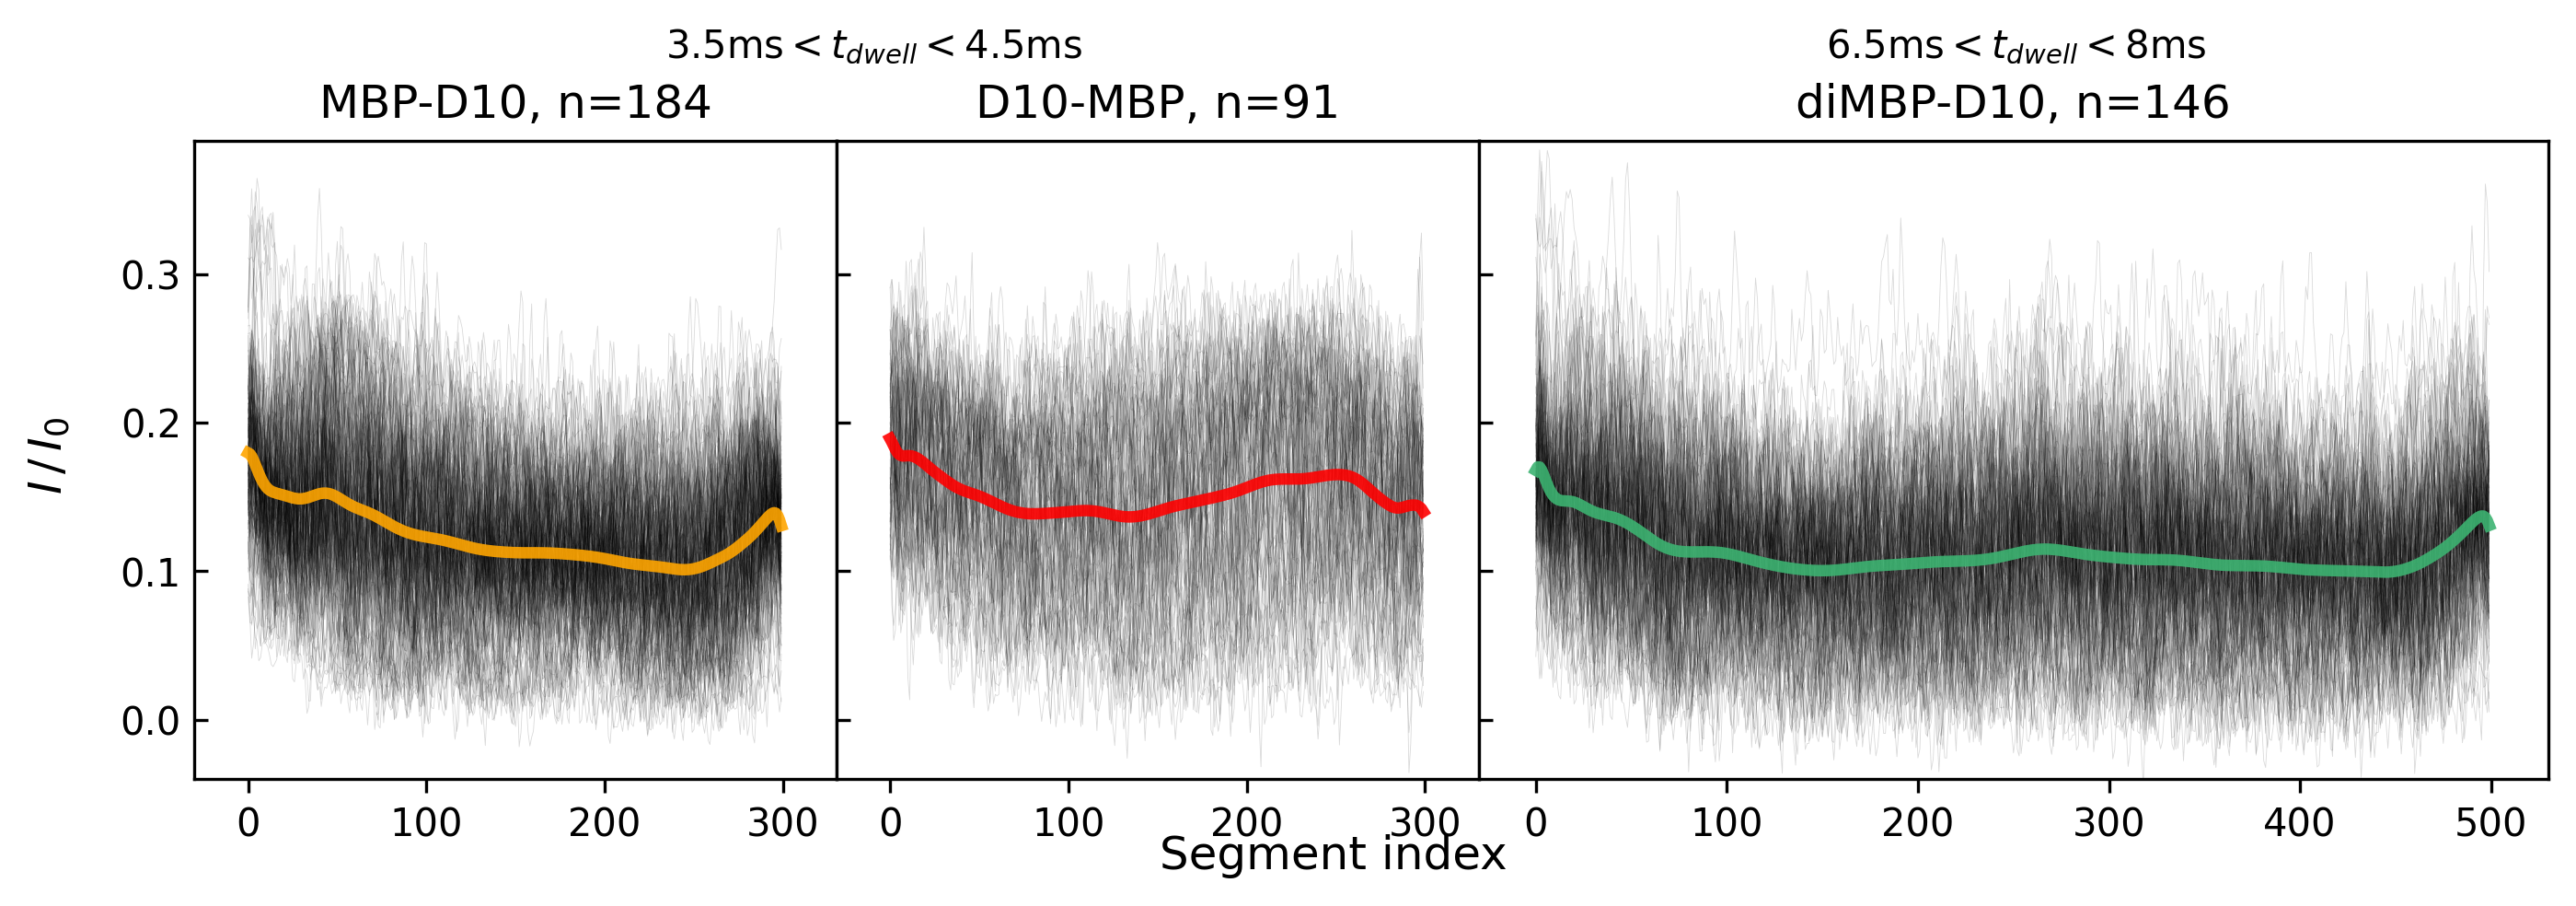

In [15]:
# save the generated figure (what is currently stored in variable "fig")
# modify the file name to generate unique SVG files containing the active figure "fig"

plt.figure(fig)
##plt.savefig(os.path.join(os.getcwd(),f"dtw_fig_exports\\DTW_3.5-4.5_6.5-8_labeled.svg"))